# NGRAM HDC METHOD

In [1]:
# Import Basic Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import time

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from os import listdir

## Data Insights and Pre-Processing

In [2]:
### Function: Collects sample data from files in Stanford Dataset Subfolders
    ## Inputs: folderpath: Path to Desired Folder
    ##         sentiment:  Sentiment Value (0 or 1)
    ## Output: df: Pandas Dataframe of all Sample Data found in desired folder
def stanfordDatasetFolderDataLoader(folderpath, sentiment):
    file_list=listdir(folderpath)

    df = pd.DataFrame(columns = ['Review', 'Sentiment'])
    for file in file_list:
        filepath=folderpath + file
        f = open(filepath,'r', encoding="utf-8")
        sample = f.read()
        f.close()
        df = df.append({'Review' : sample, 'Sentiment' : sentiment}, ignore_index = True)
    return df

# Choose Dataset (0: Sentiment140, 1: Stanford IMBD Dataset)
dataset = 1

# Load Dataset
if (dataset==0):
    print('Using Sentiment140 Twitter Dataset...')
    # Read in Sentiment140 data from CSV
    df = pd.read_csv('./Sentiment140_Tweets/data.csv')
    df.columns =['Sentiment', 'IDs', 'Date', 'Flag', 'User', 'Tweet']
else:
    print('Using Stanford IMBD Movie Review Dataset...')
    # Read in Training Stanford IMBD Movie Review data from subfolders
    train_pos=stanfordDatasetFolderDataLoader('./StanfordMovie/train/pos/',1)
    train_neg=stanfordDatasetFolderDataLoader('./StanfordMovie/train/neg/',0)
    train_df=pd.concat([train_pos, train_neg], axis=0)
    
    # Read in Testing Stanford IMBD Movie Review data from subfolders
    test_pos=stanfordDatasetFolderDataLoader('./StanfordMovie/test/pos/',1)
    test_neg=stanfordDatasetFolderDataLoader('./StanfordMovie/test/neg/',0)
    test_df=pd.concat([test_pos, test_neg], axis=0)

    df=pd.concat([train_df, test_df], axis=0)
print('Total number of Samples In Dataset:', len(df))

Using Stanford IMBD Movie Review Dataset...
Total number of Samples In Dataset: 50000


In [3]:
# Dataset Cleanup:

# Sentiment140 Sentiment Clean Up
if dataset==0:
    # Replace Sentiment of 4 (Positive) with 1
    df["Sentiment"].replace({4: 1}, inplace=True)
    # Eliminate Neutral Tweets, if any
    df = df[df['Sentiment'] != 2]

# Check for Null Values
if ( not df.isnull().values.any() ):
    print("Dataset in Use has No NULL values.")
else:
    df.dropna(inplace=True)

print("Dataset Length after Cleanup:", len(df))

Dataset in Use has No NULL values.
Dataset Length after Cleanup: 50000


In [4]:
# Downsample the Dataset to 5000 Total Samples
percentage=5000/len(df)
df_downsampled = df.sample(frac=percentage,random_state=0)
df_downsampled

,Review,Sentiment
11841,"Often tagged as a comedy, The Man In The White...",1
7102,After Chaplin made one of his best films: Doug...,0
8019,I think the movie was one sided I watched it r...,0
747,I have fond memories of watching this visually...,1
5142,This episode had potential. The basic premise ...,0
...,...,...
9869,Reading the various external reviews of Roger ...,1
4692,To soccer fans every where -- stay away from t...,0
12143,This is such a great movie to watch with young...,1
9963,have just got back from seeing this brilliantl...,1


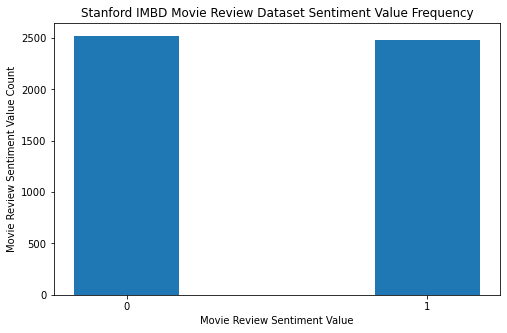

Where Sentiment is Positive when Sentiment Value = 1 and Negative when Sentiment Value = 0


In [5]:
# Visualization of Dataset Sentiment Outcomes - Ensured Even Distribution of Outcomes
sent_count = df_downsampled['Sentiment'].value_counts()
plt.figure(figsize=(8, 5))
w = 0.35  
plt.bar(x=np.arange(len(sent_count)), height=sent_count, width = w)
plt.xticks(np.arange(len(sent_count)), sent_count.index.tolist())

if dataset==0:
    plt.xlabel('Tweet Sentiment Value')
    plt.ylabel('Tweet Sentiment Value Count')
    plt.title('Sentiment140 Twitter Dataset Sentiment Value Frequency')
else:
    plt.xlabel('Movie Review Sentiment Value')
    plt.ylabel('Movie Review Sentiment Value Count')
    plt.title('Stanford IMBD Movie Review Dataset Sentiment Value Frequency')
plt.show()
print('Where Sentiment is Positive when Sentiment Value = 1 and Negative when Sentiment Value = 0')

In [6]:
### Function: Encodes Characters in Samples to Numerical Values
    ## Input: SamplesArray: Array of Samples with Characters
    ## Output: X_: Array of Samples with Numberical Values
def charEnc(SamplesArray):
    X_ = []
    for sample in SamplesArray:
            token_item = []
            for letter in sample.lower():
                if ord(letter) >= ord('a') and ord(letter) <= ord('z'):
                    token_item.append(ord(letter) - ord('a') + 11)
                elif ord(letter) >= ord('0') and ord(letter) <= ord('9'):
                    token_item.append(ord(letter) - ord('0') + 1)
                elif letter == ' ':
                    token_item.append(-1)
                else:
                    pass
            X_.append(token_item)
    return X_

# Encode the Samples
if dataset==0:
    Xdf = charEnc(df_downsampled['Tweet'])
else:
    Xdf = charEnc(df_downsampled['Review'])

# Get Final Train/Test Sets:
TrainXdf,TestXdf, TrainYdf, TestYdf = train_test_split(Xdf, df_downsampled['Sentiment'],test_size=.2, random_state=2)
TrainYdf=np.array(TrainYdf)
TestYdf=np.array(TestYdf)
TrainXdf[0]

[30,
 18,
 15,
 -1,
 23,
 25,
 30,
 19,
 25,
 24,
 -1,
 26,
 19,
 13,
 30,
 31,
 28,
 15,
 -1,
 11,
 29,
 29,
 25,
 13,
 19,
 11,
 30,
 19,
 25,
 24,
 -1,
 25,
 16,
 -1,
 11,
 23,
 15,
 28,
 19,
 13,
 11,
 -1,
 18,
 11,
 29,
 -1,
 29,
 15,
 15,
 24,
 -1,
 16,
 19,
 30,
 -1,
 30,
 25,
 -1,
 11,
 14,
 32,
 19,
 29,
 15,
 -1,
 26,
 25,
 30,
 15,
 24,
 30,
 19,
 11,
 22,
 -1,
 32,
 19,
 15,
 33,
 15,
 28,
 29,
 -1,
 11,
 24,
 14,
 -1,
 30,
 18,
 19,
 29,
 -1,
 19,
 29,
 -1,
 26,
 11,
 28,
 30,
 19,
 13,
 31,
 22,
 11,
 28,
 22,
 35,
 -1,
 31,
 29,
 15,
 16,
 31,
 22,
 -1,
 30,
 25,
 -1,
 26,
 11,
 28,
 15,
 24,
 30,
 29,
 -1,
 11,
 24,
 14,
 -1,
 17,
 31,
 11,
 28,
 14,
 19,
 11,
 24,
 29,
 -1,
 30,
 18,
 11,
 30,
 -1,
 30,
 18,
 19,
 29,
 -1,
 16,
 19,
 22,
 23,
 -1,
 33,
 18,
 19,
 13,
 18,
 -1,
 19,
 29,
 -1,
 18,
 15,
 28,
 15,
 12,
 35,
 -1,
 30,
 19,
 30,
 22,
 15,
 14,
 -1,
 16,
 28,
 25,
 29,
 30,
 12,
 19,
 30,
 15,
 -1,
 19,
 29,
 -1,
 17,
 19,
 32,
 15,
 24,
 -1,
 11,
 -1,
 28,


## Pre-Training Initialization
### Item Memory Generation

In [7]:
### Function: Item Memory Generation
    ## Inputs: dim: Number of columns (i.e. length of HV)
    ##         num_char: Number of rows (i.e. number of supported chars)
    ## Output: dictMem: Item Memory containing HVs for each supported char
def itemMemGen(dim=10000, num_char=37):
    dictMem = np.random.randint(2, size=(num_char, dim), dtype='int32')
    dictMem[dictMem == 0] = -1
    return dictMem

# Parameters:
HV_dim = 10000
num_supported_chars = 37

# Item Memory Generation
itemMem = itemMemGen(dim=HV_dim, num_char=num_supported_chars)
itemMem

array([[-1, -1, -1, ..., -1, -1,  1],
       [ 1, -1,  1, ..., -1, -1,  1],
       [ 1, -1, -1, ...,  1, -1, -1],
       ...,
       [-1, -1,  1, ..., -1,  1, -1],
       [-1, -1, -1, ...,  1,  1,  1],
       [ 1, -1,  1, ...,  1, -1, -1]])

### Training Functions

In [8]:
### Function: Encodes a Sample into a HV using NGRAM HDC Approach
    ## Inputs: sample:      Training Sample
    ##         itemMem:     Generate Item Memory
    ##         HV_dim:      Dimension of HV
    ##         n_gram_len:  Length of NGRAM
    ##         window_size: Size of sliding window
    ## Output: sample_HV: HV of inputted sample 
def encode(sample, itemMem, HV_dim=10000, n_gram_len=3, window_size=3):
    sample_HV = np.zeros(HV_dim, dtype='int32')

    for ngram_start in range(0, len(sample)-n_gram_len+1, window_size):
        roll_value=n_gram_len-1
        for j in range(n_gram_len):
            letterHV = itemMem[sample[ngram_start + j]]

            if (j==0):
                product = np.roll(letterHV,roll_value)
            elif (j==n_gram_len-1):
                product = product * letterHV
                sample_HV = np.add(sample_HV, product)
            else:
                product = product * np.roll(letterHV, roll_value)
                
            roll_value = roll_value - 1

    HV_avg = np.average(sample_HV)
    sample_HV[sample_HV > HV_avg] = 1
    sample_HV[sample_HV < HV_avg] = -1
    sample_HV[sample_HV == HV_avg] = 0
    return sample_HV

### Function: NGRAM HDC Training Function that creates an Associative Memory for the Model
    ## Inputs: X:           Training Samples
    ##         Y:           Outputs of Training Samples
    ##         itemMem:     Generated Item Memory
    ##         HV_dim:      Dimension of HV
    ##         sent_count:  Number of Possible Sentiment Values
    ##         n_gram_len:  Length of NGRAM
    ##         window_size: Size of sliding window
    ## Output: assocMem: Associative Memory 
def train(X, Y, itemMem, HV_dim, sent_count, n_gram_len, window_size):
    assocMem = np.zeros((sent_count, HV_dim), dtype='int32')
    sample_idx = 0
    
    for sample in X:
        sample_HV = encode(sample, itemMem, HV_dim, n_gram_len)
        assocMem[Y[sample_idx]] = np.add(assocMem[Y[sample_idx]], sample_HV)
        sample_idx += 1
    return assocMem

### Testing Functions

In [9]:
### Function: Compares Input HV to Class HVs and Returns the Predicted Class
    ## Inputs: assocMem: Model's Associative Memory
    ##         inputHV:  Encoded HV of a sample
    ## Output: pred: the predicted class
def get_prediction(assocMem, inputHV):
    pred = assocMem[0]
    maximum = np.NINF

    for index in range(len(assocMem)):
        similarity = cosine_similarity([inputHV, assocMem[index]])[0][1]  
        if (similarity > maximum):
            pred = index
            maximum = similarity

    return pred

### Function: Tests the NGRAM HDC Model and Returns Accuracy of Model
    ## Inputs: HV_dim:      Dimension of HV
    ##         n_gram_len:  Length of NGRAM
    ##         window_size: Size of sliding window
    ##         itemMem:     Generated Item Memory
    ##         assocMem:    Model's Associative Memory
    ##         TestXdf:     Test Samples
    ##         TextYdf:     Sentiment of Test Samples
    ## Output: accuracy: Accuracy of the Model
def test(HV_dim, n_gram_len, window_size, itemMem, assocMem, TestXdf, TestYdf):
    true_pos_count=0
    false_pos_count=0
    correct_count = 0

    for index in range(len(TestXdf)):
        prediction = get_prediction(assocMem, encode(TestXdf[index], itemMem, HV_dim, n_gram_len, window_size))
        if (TestYdf[index] == prediction):
            correct_count += 1
            if prediction==1:
                true_pos_count += 1
        elif prediction==1:
            false_pos_count += 1 
            
    accuracy = (correct_count / len(TestYdf)) * 100
    if (true_pos_count+false_pos_count) != 0:
        precision = (true_pos_count/ (true_pos_count+false_pos_count)) * 100
    else:
        precision=0
    return accuracy, precision

## Optimal Hyperparameter Search
### One-Shot Training/Accuracy of Various Sets of Hyperparameter Values

In [10]:
# Hyperparameters
n_gram_lens = [1, 2, 3, 4, 5]
window_sizes = [1, 0] # Option 0 is the current NGRAM length

# Optimal Result Initialization
best_acc=0
n_gram_best=0
window_size_best=0
best_assocMem=[]

# Generate Table Initialization
table_data=[]
col_names = ["NGRAM LEN", "WINDOW SIZE", "ONE-SHOT ACCURACY", "ONE-SHOT-PRECISION", "TRAINING TIME (s)", "NUMBER OF TRAINING SAMPLES", "TESTING TIME (s)", "NUMBER OF TESTING SAMPLES"]

for ngram_len in n_gram_lens:
    for window_size in window_sizes:

        # Option 0:
        if window_size==0:
            window_size=ngram_len

        # Train Model (i.e. Generate Model's Associative Memory)
        t0=time.time()
        assocMem = train(TrainXdf, TrainYdf, itemMem, HV_dim, len(sent_count), ngram_len, window_size=window_size)
        t1=time.time()
        train_time = t1-t0

        # One-Shot Training Results
        t0=time.time()
        one_shot_accuracy, one_shot_precision =test(HV_dim, ngram_len, window_size, itemMem, assocMem, TestXdf, TestYdf)
        t1=time.time()
        test_time = t1-t0

        # Add Data to Table
        data = [ngram_len, window_size, one_shot_accuracy, one_shot_precision, train_time, len(TrainYdf), test_time, len(TestYdf)]
        table_data.append(data)

        if one_shot_accuracy>best_acc:
            best_acc=one_shot_accuracy
            best_assocMem=copy.copy(assocMem)
            n_gram_best=ngram_len
            window_size_best=window_size

# Get Best Assoc Memory
assocMem=copy.copy(best_assocMem)

# Save Results to File
df=pd.DataFrame(table_data, columns=col_names)
filepath="./Results/HyperparameterResults/NGRAM_" + str(dataset) +".csv"
df.to_csv(filepath)

print("Results of Various Hyperparameter Sets")
print(tabulate(table_data, headers=col_names, tablefmt="simple"))
print("\nBest Hyperparameters: NGRAM LEN: ", n_gram_best, ", WINDOW SIZE: ", window_size_best)
print("Best One-Shot Accuracy: ", best_acc)

Results of Various Hyperparameter Sets
  NGRAM LEN    WINDOW SIZE    ONE-SHOT ACCURACY    ONE-SHOT-PRECISION    TRAINING TIME (s)    NUMBER OF TRAINING SAMPLES    TESTING TIME (s)    NUMBER OF TESTING SAMPLES
-----------  -------------  -------------------  --------------------  -------------------  ----------------------------  ------------------  ---------------------------
          1              1                 51.6                0                   29.5177                          4000             27.9622                         1000
          1              1                 51.6                0                   28.02                            4000             25.3066                         1000
          2              1                 53.2               51.2903              71.2881                          4000             62.4882                         1000
          2              2                 59.2               60.9827              71.0306                     

## Retraining Optimal Model

In [11]:
### Function: NGRAM HDC Re-Training Function that creates a New Associative Memory for the Model
    ## Inputs: X:           Training Samples
    ##         Y:           Outputs of Training Samples
    ##         itemMem:     Generated Item Memory
    ##         assocMem:    Associative Memory of Current Model
    ##         HV_dim:      Dimension of HV
    ##         n_gram_len:  Length of NGRAM
    ##         window_size: Size of sliding window
    ##         alpha:       Learning Rate Parameter
    ## Output: assocMem: New Associative Memory
def retrain(X, Y, itemMem, assocMem, HV_dim, n_gram_len, window_size, alpha):
    sample_index = 0
    for sample in X:
        sample_HV = encode(sample, itemMem, HV_dim, n_gram_len, window_size)
        prediction = get_prediction(assocMem, sample_HV)
        if prediction != Y[sample_index]:
            assocMem[Y[sample_index]] = np.add(assocMem[Y[sample_index]], alpha * sample_HV)
            assocMem[prediction] = np.subtract(assocMem[prediction], alpha * sample_HV)
        sample_index += 1
    return assocMem

# Re-Train Optimal Model with Learning Parameter
learningparam_results=[]
num_epochs = 20
print('-------- Retraining Model w Learning Parameter: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf, itemMem, assocMem, HV_dim, n_gram_best, window_size_best, alpha = num_epochs - epoch)
    acc, prec = test(HV_dim, n_gram_best, window_size_best, itemMem, assocMem, TestXdf, TestYdf)
    print('Epoch ', (epoch+1), ': ', acc)
    learningparam_results.append([acc,prec])

# Re-Train Optimal Model without Learning Parameter
assocMem=copy.copy(best_assocMem)
no_learningparam_results=[]
print('-------- Retraining Model without Learning Parameter: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf, itemMem, assocMem, HV_dim, n_gram_best, window_size_best, alpha = 1)
    acc, prec = test(HV_dim, n_gram_best, window_size_best, itemMem, assocMem, TestXdf, TestYdf)
    print('Epoch ', (epoch+1), ': ', acc)
    no_learningparam_results.append([acc,prec])

# Save All Results to Files
col_name=["Accuracy", "Precision"]

df_lp=pd.DataFrame(learningparam_results, columns=col_name)
filepath="./Results/EpochResults_LearningParam/NGRAM_" + str(dataset) +".csv"
df_lp.to_csv(filepath)

df_nlp=pd.DataFrame(no_learningparam_results, columns=col_name)
filepath="./Results/EpochResults_NoLearningParam/NGRAM_" + str(dataset) +".csv"
df_nlp.to_csv(filepath)

-------- Retraining Model w Learning Parameter:  20  Epochs --------
Epoch  1 :  77.0
Epoch  2 :  76.5
Epoch  3 :  78.2
Epoch  4 :  80.0
Epoch  5 :  80.7
Epoch  6 :  81.0
Epoch  7 :  80.7
Epoch  8 :  80.4
Epoch  9 :  81.10000000000001
Epoch  10 :  81.0
Epoch  11 :  80.80000000000001
Epoch  12 :  81.3
Epoch  13 :  80.5
Epoch  14 :  80.80000000000001
Epoch  15 :  80.30000000000001
Epoch  16 :  80.30000000000001
Epoch  17 :  80.30000000000001
Epoch  18 :  80.30000000000001
Epoch  19 :  80.30000000000001
Epoch  20 :  80.30000000000001
-------- Retraining Model without Learning Parameter:  20  Epochs --------
Epoch  1 :  81.8
Epoch  2 :  80.7
Epoch  3 :  82.6
Epoch  4 :  82.0
Epoch  5 :  82.19999999999999
Epoch  6 :  82.5
Epoch  7 :  81.69999999999999
Epoch  8 :  82.19999999999999
Epoch  9 :  82.3
Epoch  10 :  82.3
Epoch  11 :  82.19999999999999
Epoch  12 :  82.3
Epoch  13 :  82.3
Epoch  14 :  82.3
Epoch  15 :  82.3
Epoch  16 :  82.3
Epoch  17 :  82.3
Epoch  18 :  82.3
Epoch  19 :  82.3
Epo